In [4]:
library(rGREAT)
library(ComplexHeatmap)

### Borrowed from https://jokergoo.github.io/rGREAT/articles/suppl_compare_tss.html

In [7]:
tss_txdb = getTSS("TxDb.Hsapiens.UCSC.hg38.knownGene")
tss_gencode = getTSS("gencode_v40")
tss_refseq = getTSS("refseq:hg38")
tss_great = getTSS("great:hg38")

In [8]:
library(org.Hs.eg.db)

Le chargement a nécessité le package : AnnotationDbi

Le chargement a nécessité le package : Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




In [9]:
map = unlist(as.list(org.Hs.egENSEMBL2EG))
new_gene_id = map[tss_gencode$gene_id]
tss_gencode$gene_id[!is.na(new_gene_id)] = new_gene_id[!is.na(new_gene_id)]

map = unlist(as.list(org.Hs.egSYMBOL2EG))
new_gene_id = map[tss_great$gene_id]
tss_great$gene_id[!is.na(new_gene_id)] = new_gene_id[!is.na(new_gene_id)]

In [10]:
tss_lt = list(
    txdb_known_gene = tss_txdb,
    gencode = tss_gencode,
    refseq = tss_refseq,
    great = tss_great
)
tss_lt = lapply(tss_lt, sort)

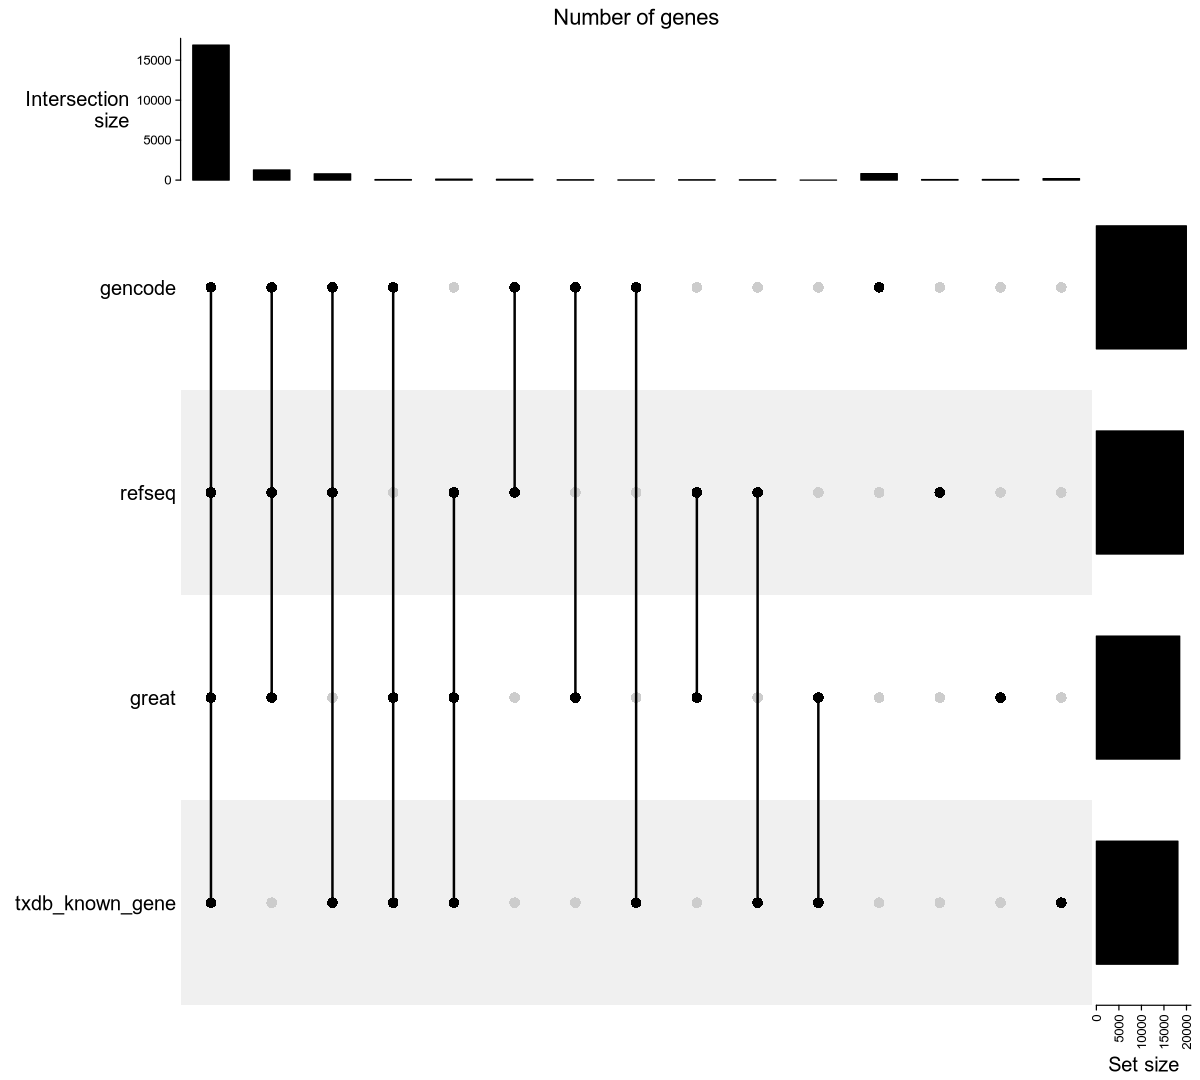

In [22]:
library(ComplexHeatmap)
options(repr.plot.width=10, repr.plot.height=9)
lt = lapply(tss_lt, function(x) {
    unique(x$gene_id)
})
cm = make_comb_mat(lt)
UpSet(cm, column_title = "Number of genes")

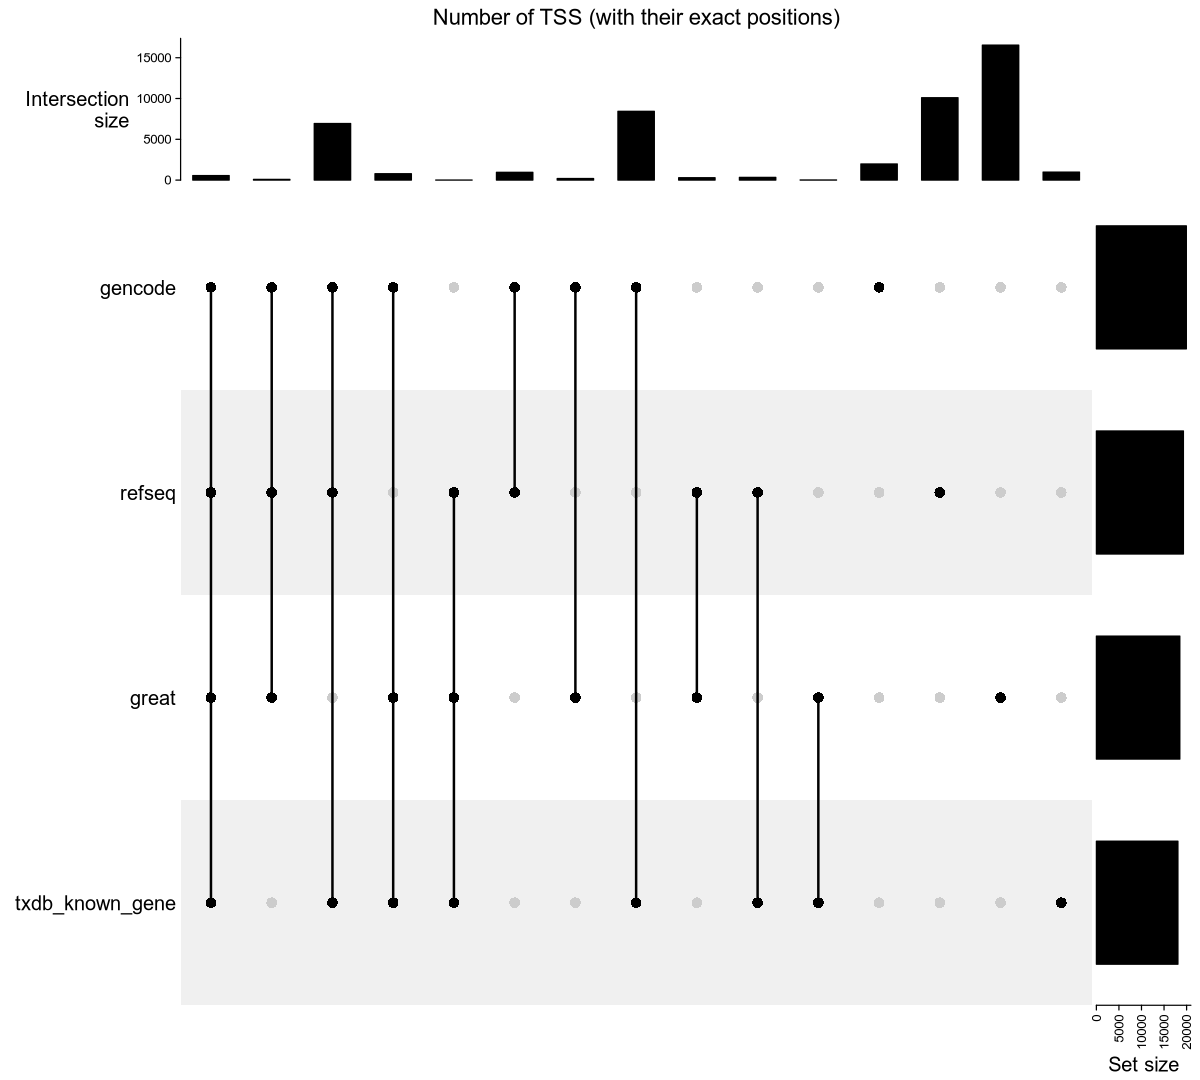

In [23]:
lt = lapply(tss_lt, function(x) {
    unique(paste0(strand(x), seqnames(x), ":", start(x)))
})
cm = make_comb_mat(lt)
UpSet(cm, column_title = "Number of TSS (with their exact positions)")

In [16]:
tss_lt2 = lapply(tss_lt, function(x) {
    tb = table(x$gene_id)
    dp = names(tb[which(tb == 1)])
    x = x[x$gene_id %in% dp]
    names(x) = x$gene_id
    x
})
cn = tss_lt2[[1]]$gene_id
for(i in 2:length(tss_lt2)) {
    cn = intersect(cn, tss_lt2[[i]]$gene_id)
}
length(cn)

[1] 16865

In [17]:
tss_lt2 = lapply(tss_lt2, function(x) x[cn])

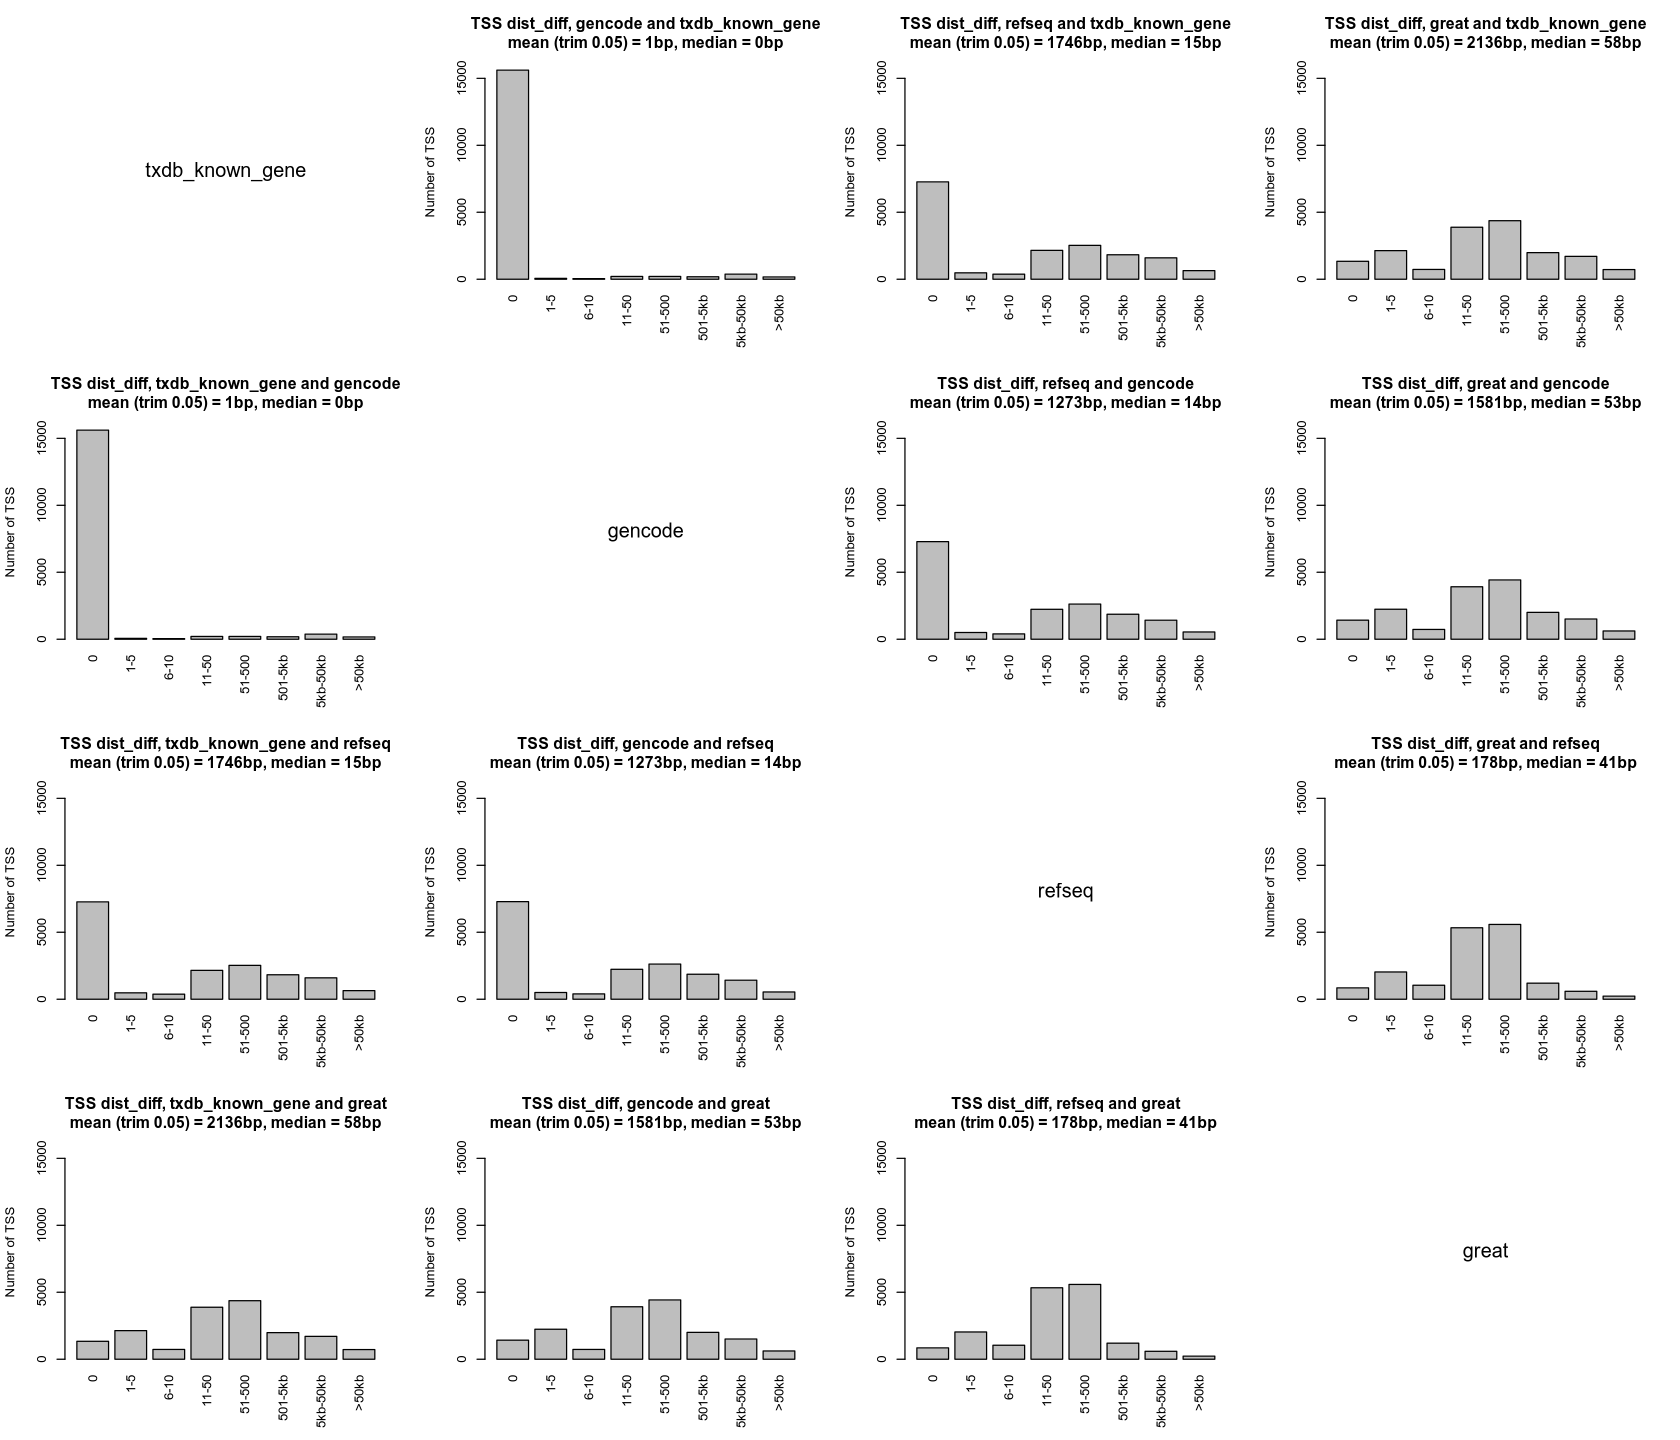

In [25]:
library(GetoptLong)
compare_tss_pos = function(tss1, tss2, name1, name2, ...) {
    d1 = start(tss1)
    d2 = start(tss2)

    diff = abs(d1 - d2)
    
    v = numeric()
    v["0"] = sum(diff == 0)
    v["1-5"] = sum(diff >= 1 & diff <= 5)
    v["6-10"] = sum(diff >= 6 & diff <= 10)
    v["11-50"] = sum(diff >= 11 & diff <= 50)
    v["51-500"] = sum(diff >= 51 & diff <= 500)
    v["501-5kb"] = sum(diff >= 501 & diff <= 5000)
    v["5kb-50kb"] = sum(diff >= 5001 & diff <= 50000)
    v[">50kb"] = sum(diff >= 50001)

    barplot(v, ylab = "Number of TSS", 
        main = qq("TSS dist_diff, @{name1} and @{name2}\nmean (trim 0.05) = @{round(mean(diff, trim = 0.05))}bp, median = @{median(diff)}bp"), 
        las = 3, ...)
}
options(repr.plot.width=14, repr.plot.height=12)
par(mfrow = c(4, 4))
for(i in 1:4) {
    for(j in 1:4) {
        if(i == j) {
            plot(c(0, 1), c(0, 1), type = "n", axes = FALSE, ann = FALSE)
            text(0.5, 0.5, names(tss_lt2)[i], cex = 1.5)
        } else {
            compare_tss_pos(tss_lt2[[j]], tss_lt2[[i]], names(tss_lt2)[j], names(tss_lt2)[i], ylim = c(0, 16000))
        }
    }
}


In [26]:
tss_refseq

GRanges object with 19327 ranges and 1 metadata column:
          seqnames    ranges strand |     gene_id
             <Rle> <IRanges>  <Rle> | <character>
      [1]     chr1     65419      + |       79501
      [2]     chr1    451678      - |      729759
      [3]     chr1    686654      - |       81399
      [4]     chr1    923923      + |      148398
      [5]     chr1    959256      - |       26155
      ...      ...       ...    ... .         ...
  [19323]     chrY  24833919      + |       57135
  [19324]     chrY  25052104      - |      442868
  [19325]     chrY  25622117      + |        9085
  [19326]     chrY  57067865      + |        6845
  [19327]     chrY  57184216      + |        3581
  -------
  seqinfo: 25 sequences from an unspecified genome

In [27]:
library(rtracklayer)

In [28]:
export.bed(tss_refseq, "tss_refseq.bed")